In [1]:
%run useful_functions.py

C:\Users\natha\Desktop\17-Cyber-risk_and_the_cross-section_of_stock_returns-main\17-Cyber-risk_and_the_cross-section_of_stock_returns-main\Work_Nathan\useful_functions.py:941: SyntaxWarning: invalid escape sequence '\s'
  item1A = re.sub('\s{2,}',' ', item1A)
C:\Users\natha\Desktop\17-Cyber-risk_and_the_cross-section_of_stock_returns-main\17-Cyber-risk_and_the_cross-section_of_stock_returns-main\Work_Nathan\useful_functions.py:952: SyntaxWarning: invalid escape sequence '\s'
  document = re.sub('\s{2,}',' ', document)
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\natha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


update 16


In [2]:
directory = 'Financial_values/'

price_daily_dict={}
price_monthly_dict={}
random_tickers = random.sample(os.listdir(directory), 100)
for ticker in tqdm(random_tickers):
    if ticker=="TSLA" or True:
    
        file_path = 'Financial_values/'+ticker+'/daily_prices.csv'
    
        price_table = pd.read_csv(file_path)
    
        price_table['date'] = pd.to_datetime(price_table['date'])
        price_table.set_index('date', inplace=True)
        price_table.dropna(inplace=True)

        if price_table.shape[0]==0:
            print("EMPTY : "+ticker)
            

        else: #skip if the table is empty which happens sometimes
            
        
            #adjust by split factor
            price_table["prc"]/=price_table["cfacpr"]
            price_table["openprc"]/=price_table["cfacpr"]
            price_table["bidlo"]/=price_table["cfacpr"]
            price_table["askhi"]/=price_table["cfacpr"]
        
            price_table=price_table.drop('cfacpr', axis=1)
        
            #estimation of bid-ask
            price_table["log bid ask factor"]= price_table[['prc']].rolling(window='31D').apply(bid_ask_estimator, args=(price_table,)).values
        
        
            #complete the Nan or 0
            to_be_completed = price_table["log bid ask factor"].copy().values
            to_be_completed[to_be_completed < 0.000001] = np.nan
            first_float_value_is_behind = False
            first_float_value = np.nan
            
            for i, val in enumerate(to_be_completed.copy()):
                if first_float_value_is_behind:
                    if np.isnan(val):
                        to_be_completed[i] = to_be_completed[i - 1]
                else:
                    if not(np.isnan(val)):
                        first_float_value_is_behind = True
                        first_float_value = val
            
            to_be_completed[np.isnan(to_be_completed)] = first_float_value
        
            price_table["log bid ask factor"]=to_be_completed
        
            #remember that the estimator is based on logarithm of prices!
            price_table["plus_cost"]=price_table['prc']*np.exp(price_table["log bid ask factor"]*0.5)-price_table['prc']
            price_table["minus_cost"]=price_table['prc']*np.exp(-price_table["log bid ask factor"]*0.5)-price_table['prc']
        
            #price_table["buy price"]=price_table["plus_cost"]+price_table['prc']
            #price_table["sell price"]=price_table["minus_cost"]+price_table['prc']
        
            
    
            price_daily_dict[ticker]=[np.mean(price_table["plus_cost"]/price_table["prc"]),-np.mean(price_table["minus_cost"]/price_table["prc"])]
    
            
            price_table_monthly=price_table[["plus_cost"]].resample('ME').mean()
            price_table_monthly["minus_cost"]=price_table[["minus_cost"]].resample('ME').mean().values
    
            
            
            price_table_monthly["plus_cost_last"]=price_table[["plus_cost"]].resample('ME').last().values
            price_table_monthly["minus_cost_last"]=price_table[["minus_cost"]].resample('ME').last().values
    
            price_table_monthly["prc"]=price_table[["prc"]].resample('ME').last().values
    
            price_monthly_dict[ticker]=[np.mean(price_table_monthly["plus_cost"]/price_table_monthly["prc"]),
                                      -np.mean(price_table_monthly["minus_cost"]/price_table_monthly["prc"]),
                                      np.mean(price_table_monthly["plus_cost_last"]/price_table_monthly["prc"]),
                                      -np.mean(price_table_monthly["minus_cost_last"]/price_table_monthly["prc"]),]
    

  0%|          | 0/100 [00:00<?, ?it/s]

EMPTY : NOVC


In [3]:
data_monthly = np.array([v for v in price_monthly_dict.values()])
data_daily = np.array([v for v in price_daily_dict.values()])


In [4]:
data_monthly.shape

(99, 4)

In [5]:
data_daily.shape

(99, 2)

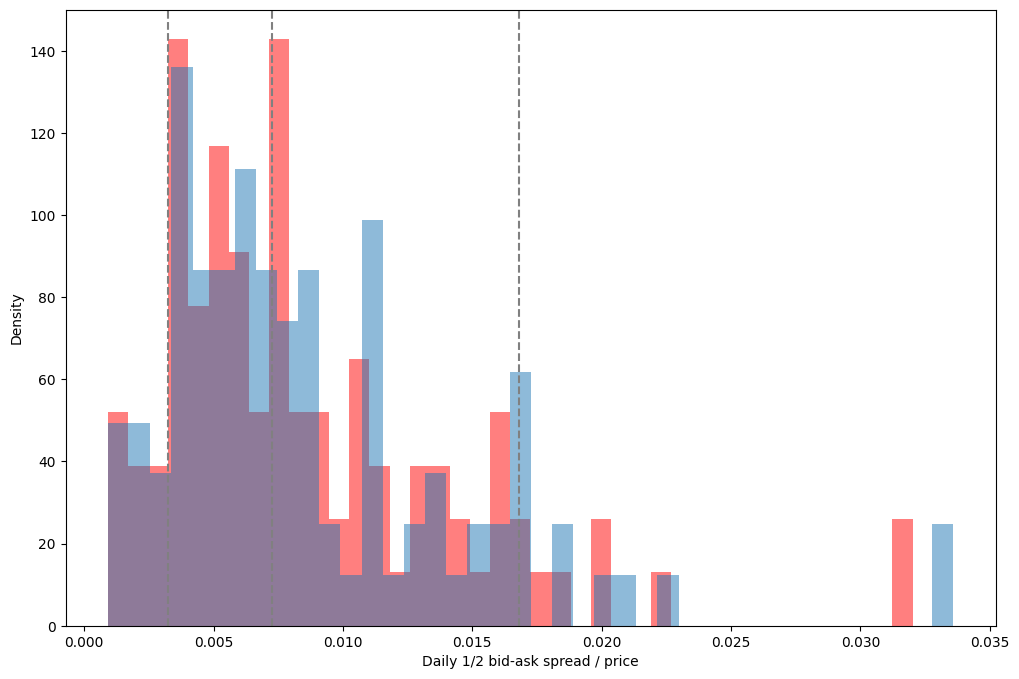

In [6]:
# Create a density histogram

plt.hist(data_daily[:,1], bins=40, density=True, alpha=0.5, color='red', label="- 1/2 bid-ask spread")
plt.hist(data_daily[:,0], bins=40, density=True, alpha=0.5, label="+ 1/2 bid-ask spread") 



# Calculate percentiles
percentiles = np.percentile(data_daily, [10, 50, 90], axis=0)

# Add vertical lines for percentiles
plt.axvline(percentiles[0, 0], color='gray', linestyle='--', label='10th percentile')
plt.axvline(percentiles[1, 0], color='gray', linestyle='--', label='50th percentile')
plt.axvline(percentiles[2, 0], color='gray', linestyle='--', label='90th percentile')


# Add labels and title
plt.xlabel('Daily 1/2 bid-ask spread / price')
plt.ylabel('Density')


# Show the plot
plt.show()

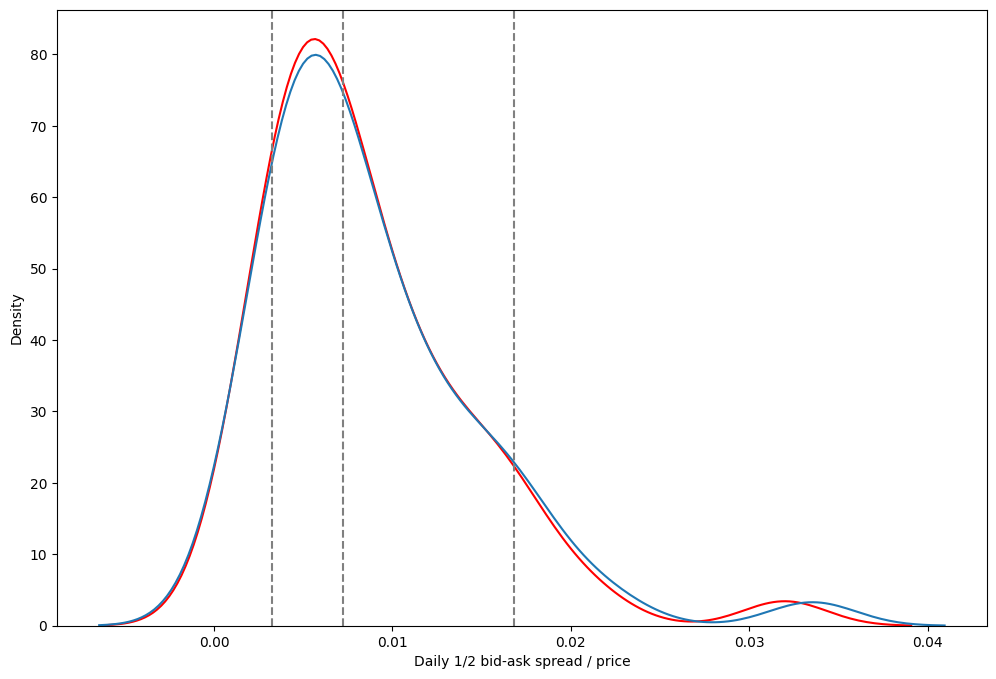

In [7]:
# Create a density histogram

sns.kdeplot(data_daily[:,1],   color='red',label="- 1/2 bid-ask spread")
sns.kdeplot(data_daily[:,0],label="+ 1/2 bid-ask spread")

# Calculate percentiles
percentiles = np.percentile(data_daily, [10, 50, 90], axis=0)

# Add vertical lines for percentiles
plt.axvline(percentiles[0, 0], color='gray', linestyle='--', label='10th percentile')
plt.axvline(percentiles[1, 0], color='gray', linestyle='--', label='50th percentile')
plt.axvline(percentiles[2, 0], color='gray', linestyle='--', label='90th percentile')



# Add labels and title
plt.xlabel('Daily 1/2 bid-ask spread / price')
plt.ylabel('Density')


# Show the plot
plt.show()

In [8]:
index_min=np.argmin(data_daily[:,0])
index_max=np.argmax(data_daily[:,0])

print(list(price_daily_dict.keys())[index_min])
print(list(price_daily_dict.keys())[index_max])

KAIR
EROX


In [9]:
top_5_indices = list(np.argpartition(data_daily[:,0], -5)[-5:])

for i in top_5_indices:
    
    print(list(price_daily_dict.keys())[i])

MCHM
NCEM
EROX
GRNQ
POSI


In [10]:
# Find the indices of the bottom 5 minimum values
bottom_5_indices = list(np.argpartition(data_daily[:,0], 5)[:5])

# Print the keys corresponding to the bottom 5 values
for i in bottom_5_indices:
    print(list(price_daily_dict.keys())[i])

KAIR
GSQD
FCAX
DCRD
OMEG


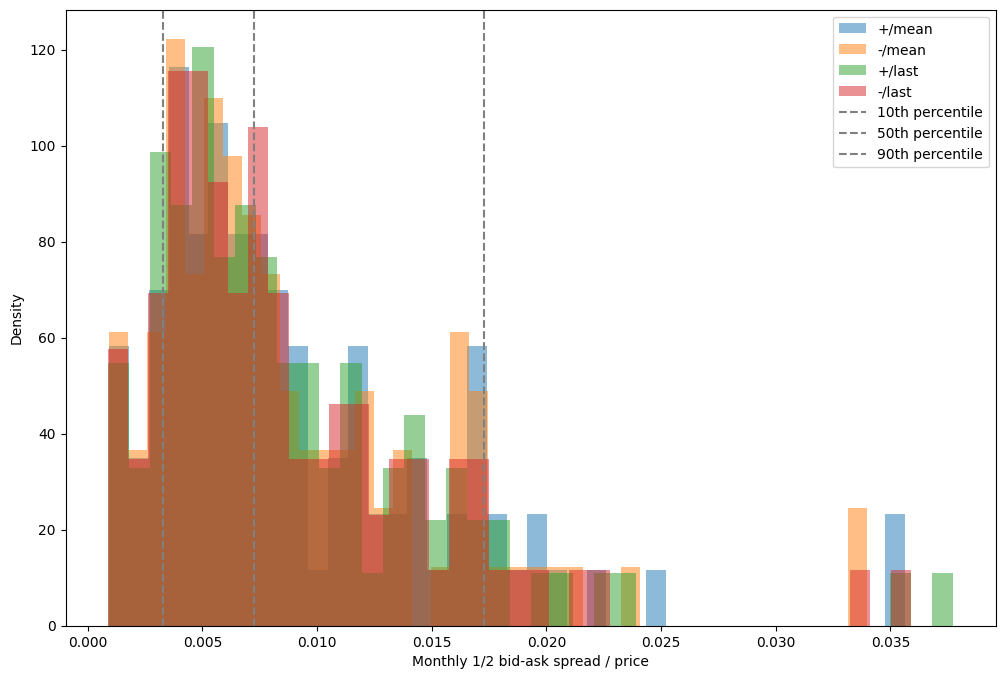

In [11]:
# Create density histograms
plt.hist(data_monthly[:, 0], bins=40, density=True, alpha=0.5, label="+/mean")
plt.hist(data_monthly[:, 1], bins=40, density=True, alpha=0.5, label="-/mean")
plt.hist(data_monthly[:, 2], bins=40, density=True, alpha=0.5, label="+/last")
plt.hist(data_monthly[:, 3], bins=40, density=True, alpha=0.5, label="-/last")

# Calculate percentiles
percentiles = np.percentile(data_monthly, [10, 50, 90], axis=0)

# Add vertical lines for percentiles
plt.axvline(percentiles[0, 0], color='gray', linestyle='--', label='10th percentile')
plt.axvline(percentiles[1, 0], color='gray', linestyle='--', label='50th percentile')
plt.axvline(percentiles[2, 0], color='gray', linestyle='--', label='90th percentile')

# Add labels and title
plt.xlabel('Monthly 1/2 bid-ask spread / price')
plt.ylabel('Density')

plt.legend()

# Show the plot
plt.show()

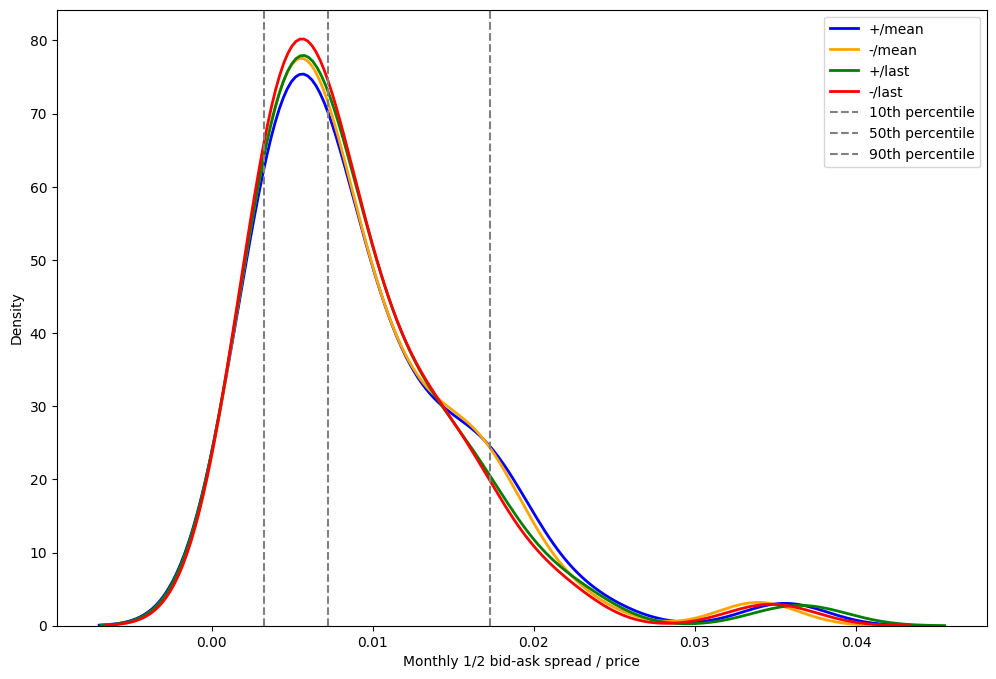

In [12]:
# Create KDE plots
sns.kdeplot(data_monthly[:, 0], color='blue', linewidth=2, label="+/mean")
sns.kdeplot(data_monthly[:, 1], color='orange', linewidth=2, label="-/mean")
sns.kdeplot(data_monthly[:, 2], color='green', linewidth=2, label="+/last")
sns.kdeplot(data_monthly[:, 3], color='red', linewidth=2, label="-/last")

# Calculate percentiles
percentiles = np.percentile(data_monthly, [10, 50, 90], axis=0)

# Add vertical lines for percentiles
plt.axvline(percentiles[0, 0], color='gray', linestyle='--', label='10th percentile')
plt.axvline(percentiles[1, 0], color='gray', linestyle='--', label='50th percentile')
plt.axvline(percentiles[2, 0], color='gray', linestyle='--', label='90th percentile')

# Add labels and title
plt.xlabel('Monthly 1/2 bid-ask spread / price')
plt.ylabel('Density')

plt.legend()

# Show the plot
plt.show()

In [13]:
directory = 'Financial_values/'
firms = ["AAPL", "MSFT", "AMZN", "GOOGL", "FB", "TSLA", "NVDA", "JPM", "V", "BABA"]
price_daily_dict={}
price_monthly_dict={}
for ticker in tqdm(os.listdir(directory)):
    if ticker in firms:
    
        file_path = 'Financial_values/'+ticker+'/daily_prices.csv'
    
        price_table = pd.read_csv(file_path)
    
        price_table['date'] = pd.to_datetime(price_table['date'])
        price_table.set_index('date', inplace=True)
        price_table.dropna(inplace=True)

        if price_table.shape[0]==0:
            print("EMPTY : "+ticker)
            

        else: #skip if the table is empty which happens sometimes
            
        
            #adjust by split factor
            price_table["prc"]/=price_table["cfacpr"]
            price_table["openprc"]/=price_table["cfacpr"]
            price_table["bidlo"]/=price_table["cfacpr"]
            price_table["askhi"]/=price_table["cfacpr"]
        
            price_table=price_table.drop('cfacpr', axis=1)
        
            #estimation of bid-ask
            price_table["log bid ask factor"]= price_table[['prc']].rolling(window='31D').apply(bid_ask_estimator, args=(price_table,)).values
        
        
            #complete the Nan or 0
            to_be_completed = price_table["log bid ask factor"].copy().values
            to_be_completed[to_be_completed < 0.000001] = np.nan
            first_float_value_is_behind = False
            first_float_value = np.nan
            
            for i, val in enumerate(to_be_completed.copy()):
                if first_float_value_is_behind:
                    if np.isnan(val):
                        to_be_completed[i] = to_be_completed[i - 1]
                else:
                    if not(np.isnan(val)):
                        first_float_value_is_behind = True
                        first_float_value = val
            
            to_be_completed[np.isnan(to_be_completed)] = first_float_value
        
            price_table["log bid ask factor"]=to_be_completed
        
            #remember that the estimator is based on logarithm of prices!
            price_table["plus_cost"]=price_table['prc']*np.exp(price_table["log bid ask factor"]*0.5)-price_table['prc']
            price_table["minus_cost"]=price_table['prc']*np.exp(-price_table["log bid ask factor"]*0.5)-price_table['prc']
        
            #price_table["buy price"]=price_table["plus_cost"]+price_table['prc']
            #price_table["sell price"]=price_table["minus_cost"]+price_table['prc']
        
            
    
            price_daily_dict[ticker]=[np.mean(price_table["plus_cost"]/price_table["prc"]),-np.mean(price_table["minus_cost"]/price_table["prc"])]
    
            
            price_table_monthly=price_table[["plus_cost"]].resample('ME').mean()
            price_table_monthly["minus_cost"]=price_table[["minus_cost"]].resample('ME').mean().values
    
            
            
            price_table_monthly["plus_cost_last"]=price_table[["plus_cost"]].resample('ME').last().values
            price_table_monthly["minus_cost_last"]=price_table[["minus_cost"]].resample('ME').last().values
    
            price_table_monthly["prc"]=price_table[["prc"]].resample('ME').last().values
    
            price_monthly_dict[ticker]=[np.mean(price_table_monthly["plus_cost"]/price_table_monthly["prc"]),
                                      -np.mean(price_table_monthly["minus_cost"]/price_table_monthly["prc"]),
                                      np.mean(price_table_monthly["plus_cost_last"]/price_table_monthly["prc"]),
                                      -np.mean(price_table_monthly["minus_cost_last"]/price_table_monthly["prc"]),]
    

  0%|          | 0/7084 [00:00<?, ?it/s]

In [14]:
price_monthly_dict

{'AAPL': [0.004103802179437895,
  0.0040764762218199425,
  0.004207018938083236,
  0.00417640344253356],
 'AMZN': [0.0054247109821506335,
  0.005374366445621447,
  0.005435177087398879,
  0.005385938850954645],
 'GOOGL': [0.003974458243571658,
  0.003949195799050956,
  0.004011818852167491,
  0.0039864802233403095],
 'JPM': [0.003549083781189763,
  0.0035227992648596113,
  0.0035368347858112784,
  0.0035111377625905095],
 'MSFT': [0.002958030420091304,
  0.002944955461326474,
  0.0029904590090883356,
  0.0029769938077564674],
 'NVDA': [0.006104118021285743,
  0.006044089783661262,
  0.005715801449956545,
  0.005662993343472988],
 'TSLA': [0.007025063464842441,
  0.006947021825793649,
  0.006889792960533154,
  0.006818616762211179],
 'V': [0.003045956656347972,
  0.0030266534003150756,
  0.0030857128428195325,
  0.003066887549850609]}

In [15]:
price_daily_dict

{'AAPL': [0.004084602634855682, 0.0040577470549118195],
 'AMZN': [0.00539143832335881, 0.005342369958798017],
 'GOOGL': [0.004210578005896876, 0.004182907489556572],
 'JPM': [0.003558644008079837, 0.003532127398469481],
 'MSFT': [0.0029642205998153034, 0.002951159938206985],
 'NVDA': [0.00606267981799304, 0.00600350303282603],
 'TSLA': [0.007026298172147466, 0.006949825288899741],
 'V': [0.0030479023195968714, 0.0030285033435897037]}

In [16]:
#the following part works only once the bid-ask pipeline was executed

In [17]:
directory = 'Financial_values/'

price_daily_dict={}
price_monthly_dict={}
for ticker in tqdm(os.listdir(directory)):
    if ticker in firms or True:
    
        file_path = 'Financial_values/'+ticker+'/bid_ask_monthly.csv'

        no_problem=True
        try:
            price_table_monthly=pd.read_csv(file_path)
        except:
            no_problem=False

        price_table_monthly=price_table_monthly.dropna()
        
        if price_table_monthly.shape[0]==0:
            print("EMPTY : "+ticker)
            no_problem=False
            
        if no_problem:
            price_monthly_dict[ticker]=[np.mean(price_table_monthly["plus_cost"]/price_table_monthly["prc"]),
                                      -np.mean(price_table_monthly["minus_cost"]/price_table_monthly["prc"]),
                                      np.mean(price_table_monthly["plus_cost_last"]/price_table_monthly["prc"]),
                                      -np.mean(price_table_monthly["minus_cost_last"]/price_table_monthly["prc"]),]


    

  0%|          | 0/7084 [00:00<?, ?it/s]

EMPTY : ACAC
EMPTY : ACDI
EMPTY : BATRK
EMPTY : CHCR
EMPTY : CPAQ
EMPTY : FWONA
EMPTY : GSQB
EMPTY : INRD
EMPTY : KINV
EMPTY : MDTA
EMPTY : MTRY
EMPTY : NOVV
EMPTY : PARF
EMPTY : SBCM
EMPTY : SCO
EMPTY : SING
EMPTY : SPKY
EMPTY : TENK
EMPTY : THLM
EMPTY : TRTI
EMPTY : UDN
EMPTY : UVIX
EMPTY : WESC


In [18]:
data_monthly = np.array([v for v in price_monthly_dict.values()])

In [19]:
data_monthly.shape

(6961, 4)

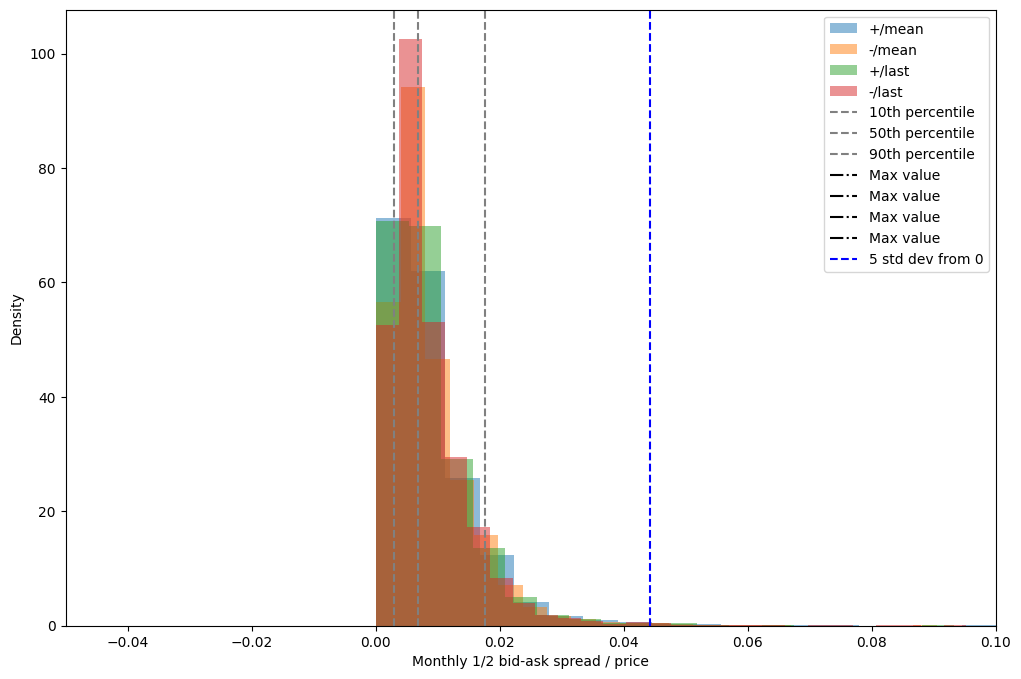

In [20]:
# Create density histograms
plt.hist(data_monthly[:, 0], bins=80, density=True, alpha=0.5, label="+/mean")
plt.hist(data_monthly[:, 1], bins=80, density=True, alpha=0.5, label="-/mean")
plt.hist(data_monthly[:, 2], bins=80, density=True, alpha=0.5, label="+/last")
plt.hist(data_monthly[:, 3], bins=80, density=True, alpha=0.5, label="-/last")

# Calculate percentiles
percentiles = np.percentile(data_monthly, [10, 50, 90], axis=0)

# Add vertical lines for percentiles
plt.axvline(percentiles[0, 0], color='gray', linestyle='--', label='10th percentile')
plt.axvline(percentiles[1, 0], color='gray', linestyle='--', label='50th percentile')
plt.axvline(percentiles[2, 0], color='gray', linestyle='--', label='90th percentile')

# Calculate and add vertical lines for maximum values
max_values = np.max(data_monthly, axis=0)
for max_val in max_values:
    plt.axvline(max_val, color='black', linestyle='-.', label='Max value')

# Calculate and add a blue vertical line at 5 standard deviations away from 0
std_dev = np.std(data_monthly)
plt.axvline(5 * std_dev, color='blue', linestyle='--', label='5 std dev from 0')

# Add labels and title
plt.xlabel('Monthly 1/2 bid-ask spread / price')
plt.ylabel('Density')

plt.legend()
plt.xlim([-0.05, 0.1])

# Show the plot
plt.show()

In [21]:
percentiles[0, 0]

0.002983674584841666

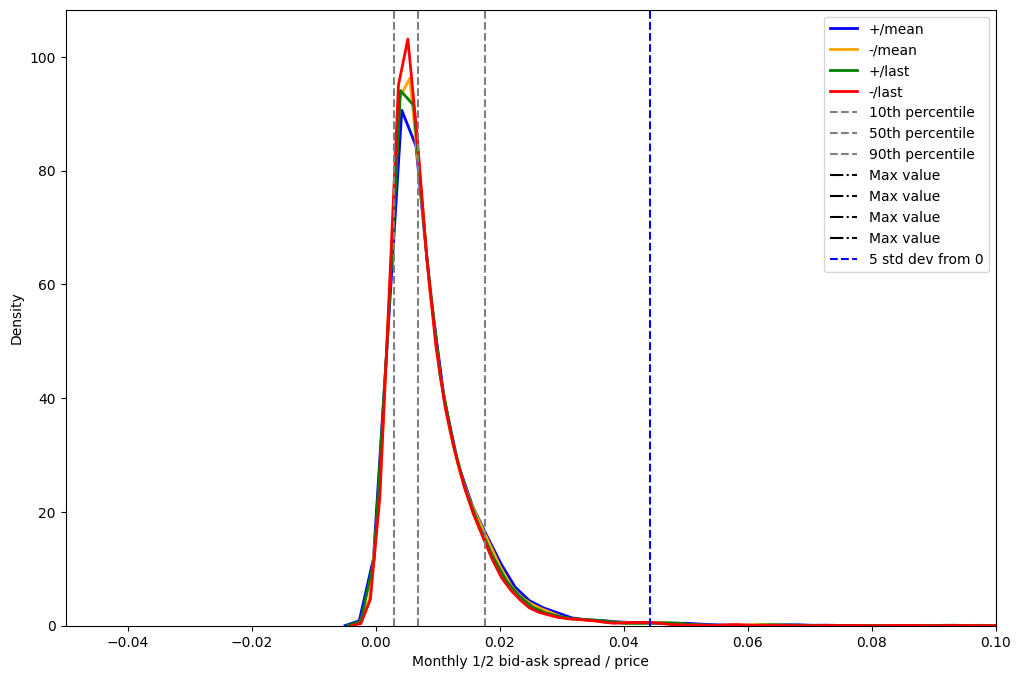

In [22]:
# Create KDE plots
sns.kdeplot(data_monthly[:, 0], color='blue', linewidth=2, label="+/mean")
sns.kdeplot(data_monthly[:, 1], color='orange', linewidth=2, label="-/mean")
sns.kdeplot(data_monthly[:, 2], color='green', linewidth=2, label="+/last")
sns.kdeplot(data_monthly[:, 3], color='red', linewidth=2, label="-/last")

# Calculate percentiles
percentiles = np.percentile(data_monthly, [10, 50, 90], axis=0)

# Add vertical lines for percentiles
plt.axvline(percentiles[0, 0], color='gray', linestyle='--', label='10th percentile')
plt.axvline(percentiles[1, 0], color='gray', linestyle='--', label='50th percentile')
plt.axvline(percentiles[2, 0], color='gray', linestyle='--', label='90th percentile')


# Calculate and add vertical lines for maximum values
max_values = np.max(data_monthly, axis=0)
for max_val in max_values:
    plt.axvline(max_val, color='black', linestyle='-.', label='Max value')


# Calculate and add a blue vertical line at 5 standard deviations away from 0
std_dev = np.std(data_monthly)
plt.axvline(5 * std_dev, color='blue', linestyle='--', label='5 std dev from 0')

# Add labels and title
plt.xlabel('Monthly 1/2 bid-ask spread / price')
plt.ylabel('Density')

plt.legend()
plt.xlim([-0.05,0.1])


# Show the plot
plt.show()